In [ ]:
!pip install spectral

     |████████████████████████████████| 212 kB 4.0 MB/s 


In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,10)

In [ ]:
# Bibliotecas
import tifffile as tif
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, medfilt
from spectral import *

In [ ]:
# Leitura da imagem
img = tif.imread('/content/drive/MyDrive/Live PDI Python/MODIS.tif')

In [ ]:
# Savitsky-Golay
sav = savgol_filter(img, 13,3, axis=2)

In [ ]:
# MNF
signal = calc_stats(img)
noise = noise_from_diffs(img)
mnfr = mnf(signal, noise)
denoised = mnfr.denoise(img, num=50)

In [ ]:
# Mediana
median= medfilt(img)

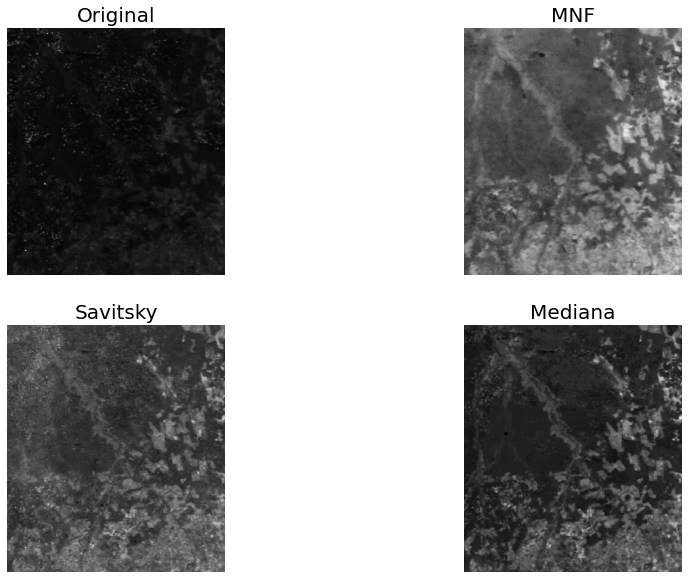

In [ ]:
# Visualizando resultado na imagem
stack = [img[:,:,10], denoised[:,:,10], sav[:,:,10], median[:,:,10]]
nomes = ['Original', 'MNF', 'Savitsky', 'Mediana']
fig,axes = plt.subplots(2,2,figsize=(15,10),sharex='all', sharey='all') 
axes = axes.ravel() 
for i in range(4): 
  axes[i].imshow(stack[i],cmap='gray') 
  axes[i].set_title(nomes[i],fontsize=20) 
  axes[i].axis('off')

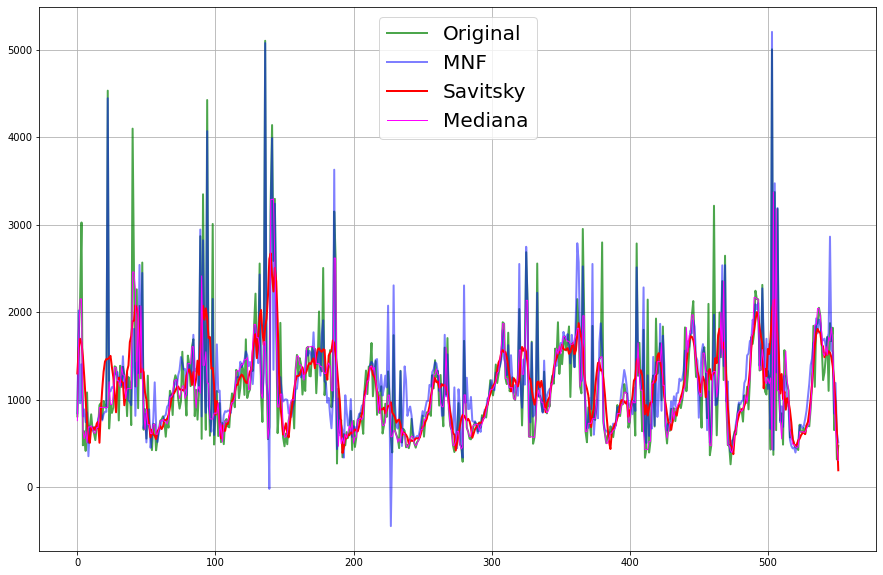

In [ ]:
# Visualizando resultado no espectro
plt.plot(img[350,500,:], color = 'green', linewidth=2, alpha=0.7)
plt.plot(denoised[350,500,:], color = 'blue', linewidth=2, alpha=0.5)
plt.plot(sav[350,500,:], color = 'red', linewidth=2)
plt.plot(median[350,500,:], color = 'magenta', linewidth=1)
plt.grid()
plt.legend(labels=nomes, fontsize=20)
plt.show()

In [ ]:
# Bibliotecas
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
import numpy as np
import math

In [ ]:
# Empilhando bandas a serem analisadas
stack = np.dstack([denoised[:,:,10], sav[:,:,10], median[:,:,10]])

# Calculando rmse global (um valor para toda cena)
rmse = [round(math.sqrt(mse(img[:,:,10],stack[:,:,i])), 
              3) for i in range(stack.shape[2])]

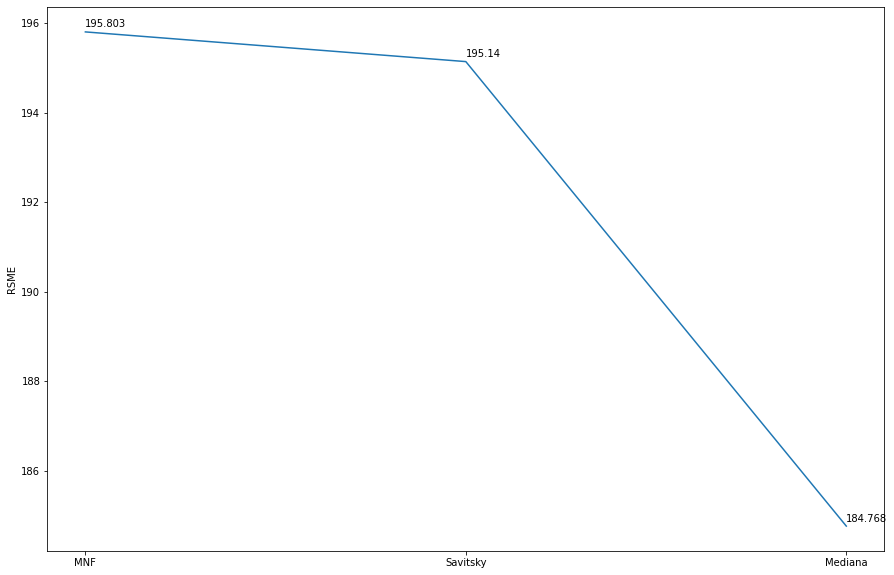

In [ ]:
# Visualizando rmse global
nom = ['MNF', 'Savitsky', 'Mediana']

plt.plot([0,1,2],rmse)
plt.xticks([0,1,2], nom)
plt.ylabel('RSME')

for index, data in enumerate(rmse):
    plt.text(x=index, y= data + 0.1, s=f"{data}")
plt.show()

In [ ]:
# Definindo função para cálculo do rmse pixel a pixel
def erro(img1, img2):
  im1 = img1.flatten()
  im2 = img2.flatten()
  rmse2 = np.zeros_like(im1)

  for i in range(len(rmse2)):
      rmse2[i] = round(np.sqrt(((im1[i] - im2[i]) ** 2).mean()), 3)
      
  return rmse2.reshape(img1.shape)

In [ ]:
# Calculando rmse pixel a pixel e armazenando na variável "result"
original = img[:,:,10]

result = np.zeros_like(stack)
for i in range(stack.shape[2]):
  result[:,:,i] = erro(original,stack[:,:,i])

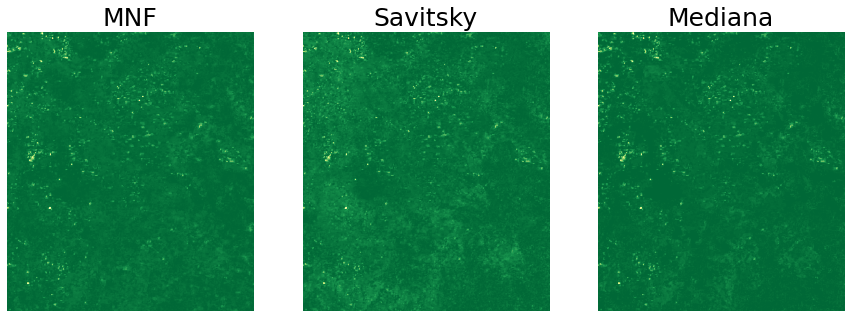

In [ ]:
# Visualizando distribuição do erro na imagem (pixel a pixel)
fig,axes = plt.subplots(1,3,sharex='all', sharey='all') 
axes = axes.ravel() 
for i in range(result.shape[2]): 
  axes[i].imshow(result[:,:,i],cmap='RdYlGn_r') 
  axes[i].set_title(nom[i],fontsize=25) 
  axes[i].axis('off')

In [ ]:
# Biblioteca
import matplotlib.pyplot as plt
from sklearn import linear_model
import pandas as pd

In [ ]:
# Empilhando imagens
stack_final = np.dstack([img[:,:,10],denoised[:,:,10], sav[:,:,10],
                         median[:,:,10]])

In [ ]:
# Transformando bandas em linhas de matriz
Matriz = np.zeros((stack_final[:,:,0].size,4))
for i in range(stack_final.shape[2]):
    vetor = stack_final[:,:,i].flatten() 
    Matriz[:,i] = vetor

In [ ]:
# Transformando matriz em dataframe
dataframe = pd.DataFrame(Matriz)
dataframe.columns = ['Original','MNF', 'Savitsky', 'Mediana']

In [ ]:
# Separando variáveis (passo necessário para o cálculo da regressão)
X = dataframe['Original'].values.reshape(-1, 1)
y1 = dataframe['MNF'].values.reshape(-1, 1)
y2 = dataframe['Savitsky'].values.reshape(-1, 1)
y3 = dataframe['Mediana'].values.reshape(-1, 1)

In [ ]:
# Armazenando variáveis y para iterar
lista_y = [y1,y2,y3]

In [ ]:
# Gerando listas com os modelos para cada filtro e os coeficientes
lista = []
lista2 = []
for i in range(len(lista_y)):
  reg = linear_model.LinearRegression()
  modelo = reg.fit(X,lista_y[i])
  reta = modelo.predict(X)
  r2 = modelo.score(X,lista_y[i])
  lista.append(reta)
  lista2.append(r2)

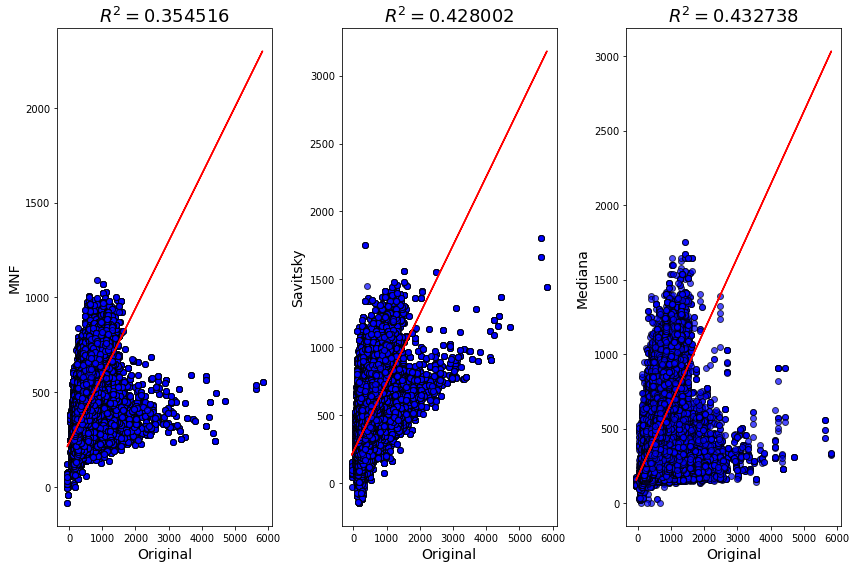

In [ ]:
# Visualizando resultado
fig, ax = plt.subplots(1,3,figsize=(12, 8))
nom = ['MNF', 'Savitsky', 'Mediana']

for i in range(len(lista_y)):
  ax[i].plot(X, lista[i], color='r')
  ax[i].scatter(X,lista_y[i], edgecolor='k', facecolor='blue', 
                alpha=0.7)
  ax[i].set_title('$R^2= %f$' % lista2[i], fontsize=18)
  ax[i].set_ylabel(nom[i], fontsize=14)
  ax[i].set_xlabel('Original', fontsize=14)

  fig.tight_layout()